# UNDERSTANDING SENTIMENTS IN EPINIONS

In this project, we are analysing customer reviews for Fuji Digital Camera obtained from Epinions data.com. Given data consists 50% of the reviews about Digital Cameras and remining 50% is about Automobiles.

For every record, we are considering the review "TEXT" and "Label" value after where “Yes” means that a consumer recommends that product and “No” denotes the opposite.

We split the data into two parts: Train and Test and identify the best classification model. We then validate the performance of this model on Automobile data.


## Index
- [Libraries](#Libraries)
- [Data Loading](#Data-Loading)
    - [Identify Fuji Reviews](#Identify-Fuji-Reviews)
    - [Data Exploration](#Data-Exploration)
- [Data Cleaning](#Data-Cleaning)
- [Feature Construction](#Feature-Construction)
- [Feature Extraction/Selection](#Feature-Extraction/Selection)
- [Data Processing](#Data-Processing)
- [Modelling](#Modelling)
- [Metrics](#Metrics)
- [Validation](#Validation)

## Libraries

This project has been developed using Python 2.7. Following libraries are loaded for Data processing, Data visualization and Data Modelling.

In [2]:
# Load required libraries 
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
import string
from string import digits
import re
import sklearn
from collections import Counter
from bs4 import BeautifulSoup

In [4]:
# Libraries & parameters used for visualization
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
colors = ['cobalt', 'orangey yellow', 'steel grey', 'tomato', 'dark lilac', 'bluish green']
cmap = sns.xkcd_palette(colors)
import matplotlib.pyplot as plt

## Data Loading

In this secion, we will load the data downloaded from epinions.com. The data consists of more than 10,000 reviews about Camera/Automobiles. We will extract reviews related to Fuji Digital Cameras and explore data using visualization techniques.

In [5]:
# Set path of the epinions file
filepath = os.path.join('..\Datasets\D1.txt')

In [6]:
# Load data from file
with open(filepath) as myfile:
    data = myfile.read()

In [7]:
# Using BeautifulSoup to parse the data
soup = BeautifulSoup(data, 'lxml')

In [29]:
print soup.prettify()[:199]

<html>
 <body>
  <doc>
   <docid>
    36
   </docid>
   <product>
    Digital_Cameras/Casio_QV_4000_4_0_Megapixel_Digital_Camera_EX_Plus_Outfit__Camera_QV4000EXK
   </product>
   <label>
    Yes
    


In [10]:
# Split all the documents in the file
documents = soup.find_all('doc')

In [11]:
# Total number of documents
len(documents)

12000

In [12]:
# Add the data to pandas dataframe
tab = pd.DataFrame()

for idx, doc in enumerate(documents):
    tab.loc[idx,'DOCID'] = str(doc.docid.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'PRODUCT'] =  str(doc.product.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'LABEL'] =  str(doc.label.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'RATING'] =  str(doc.rating.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'URL'] =  str(doc.url.contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'CLASS'] =  str(doc.find('class').contents[0]).strip('\n').strip(' ')
    tab.loc[idx,'TEXT'] =  doc.find('text').contents[0].strip('\n').strip(' ')

### Identify Fuji Reviews

In this section, we extract reviews related to Fuji Digital Cameras.

In [14]:
# Split the data into two dataframes by CLASS
auto = (tab[tab.CLASS == 'Auto'])
camera = (tab[tab.CLASS == 'Camera'])

In [58]:
# Filter reviews of Fuji Digital Cameras 
fuji_camera = camera[camera['PRODUCT'].str.contains("Fuji")]
fuji_camera.reset_index(inplace=True, drop=True)

In [59]:
# Total number of Fuji reviews
len(fuji_camera)

487

In [60]:
fuji_camera.head()

,DOCID,PRODUCT,LABEL,RATING,URL,CLASS,TEXT
0,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-31F6-E9DA6...,Camera,[NOTE: I have the Japanese version of this cam...
1,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-B67-D4F9A3...,Camera,"Ah, finally, A great little camera for the beg..."
2,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,5.0,http://www.epinions.com/elec-review-7463-6CD18...,Camera,"Okay, I've written three negative reviews in a..."
3,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,No,2.0,http://www.epinions.com/elec-review-2E51-6E04C...,Camera,\nThis camera is a great deal. Wal-Mart has t...
4,111,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,5.0,http://www.epinions.com/elec-review-4179-153E2...,Camera,This is a great camera. From it's picture qual...


### Data Exploration
In this section, we perform visual analysis of given data to explore the distribution of positive and negative reviews.

#### 1. Distribution of data for consumer recommending a product from Class = [Auto, Camera]

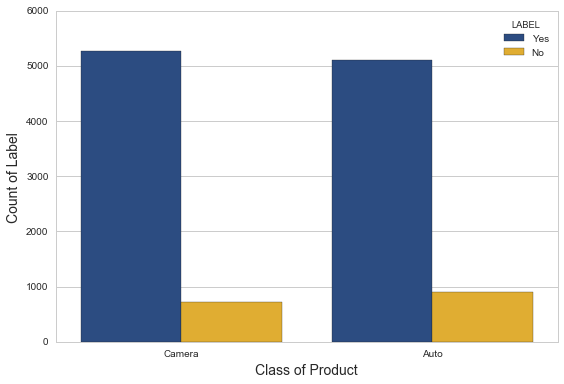

In [18]:
sns.countplot(x="CLASS", hue = "LABEL", data=tab, palette=cmap)
plt.ylabel('Count of Label', fontsize=14)
plt.xlabel('Class of Product', fontsize=14)
plt.tight_layout()

#### 2. Distribution of data for consumer ratings of products from Class = [Auto, Camera]

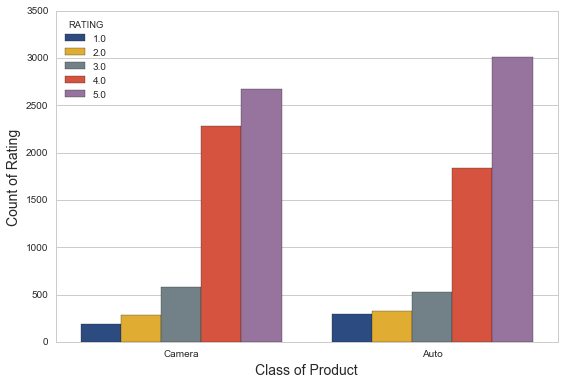

In [19]:
sns.countplot(x="CLASS", hue = "RATING", data=tab, palette = cmap)
plt.ylabel('Count of Rating', fontsize=14)
plt.xlabel('Class of Product', fontsize=14)
plt.tight_layout()

#### 3. Distribution of data for consumer ratings for Camera vs if the recommend the product or not.

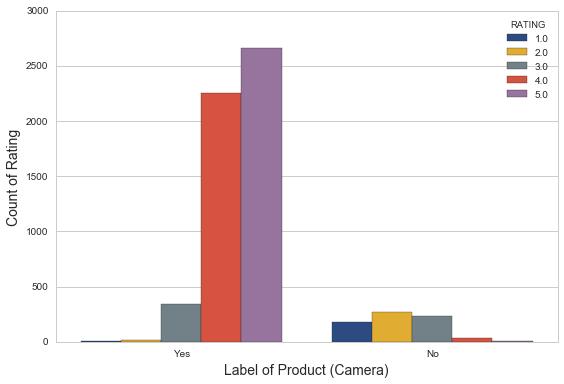

In [20]:
sns.countplot(x="LABEL", hue = "RATING", data=camera, palette = cmap)
plt.ylabel('Count of Rating', fontsize=14)
plt.xlabel('Label of Product (Camera)', fontsize=14)
plt.tight_layout()

#### 4. Distribution of data for consumer ratings for Fuji Camera vs if the recommend the product or not.

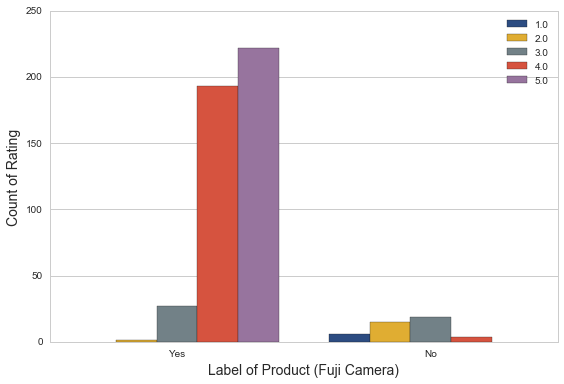

In [22]:
sns.countplot(x="LABEL", hue = "RATING", data=fuji_camera, palette = cmap)
plt.ylabel('Count of Rating', fontsize=14)
plt.xlabel('Label of Product (Fuji Camera)', fontsize=14)
plt.legend(loc='upper right')
plt.tight_layout()

From the above visualizations, we can infer that the data is highly biased with about 10% data with Label "No" and the rest with Label "Yes".

## Data Cleaning

In this section, we will create functions that clean the text of every review using regular expressions and various functions offered by nltk package.

The following function processes and tokenizes raw text. We use nltk package to tokenize and clean the text. This includes removing numbers, stopwords, punctuations, converting the text to lower case and lemmatizing.

In [23]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """
    input:
        text: string of one review
        lemmatizer: default is nltk.stem.wordnet.WordNetLemmatizer()
    output:
        result: list of tokenized words
    """
    
    tokenized = []
    lemmatized = []
    
    # Remove numbers
    text = re.sub('\d', ' ', text)
    
    # Normalizes case
    text = text.lower()
    
    # remove apostrophes, delete 's
    text = text.replace('\'s', '')
    text = text.replace('\'', ' ')
    
    # Remove punctuations  
    for char in string.punctuation:
        text = text.replace(char, ' ')
        
    # Tokenize text
    tokenized = nltk.word_tokenize(text)
    
    for word in tokenized:
        # Remove stopwords
        if word not in stopwords.words('english'):
            try:
                # lemmatize word
                lemmatized.append(lemmatizer.lemmatize(word))
            except Exception:
                pass
    return ' '.join(word for word in lemmatized)

In [24]:
# Example

text = "This is a sample test input for 's processing loves."
print process(text)

sample test input processing love


The following function makes use of the process() function that we defined earlier to clean all the text in the last column of pandas dataframe. Here, we assume the last column has all the text reviews.

In [25]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """
    Inputs
        df: pd.DataFrame: dataframe containing a column 'text' in last column
        lemmatizer: the default argument is of type nltk.stem.wordnet.WordNetLemmatizer
    Outputs
        pd.DataFrame: dataframe in which the values of text column have been changed from str to list(str),
                        the output from process_text() function. Other columns are unaffected.
    """
    df_copy = df.copy()
    df_length = len(df_copy.iloc[:,-1])
        
    temp = [process(df_copy.iloc[i,-1]) for i in range(df_length)]  
    df_copy.loc[:,'TEXT'] = temp
    
    return df_copy

## Feature Construction

In this section, we will create functions to create Bag-Of-Words feature vectors from the processed reviews. 

Since the number of possible words is large and not all of them may be useful for our classification task. We first determine which words to retain, and which to omit. Since we have already pruned the stopwords, we will now prune words that are used rarely and usually tend to be typos. We consider a word rare if it occurs not more than once.

Different approaches for parameterization of text:
- Binary: tells whether a term t is present in a document or not
- Counts: frequency of occurrences of term t in a document
- Weighted frequencies: TF-IDF (Term Frequency - Inverse Document Frequency)

Where each row in matrix corresponds to the document and each column corresponds to a different term. For simplicity, we only consider TF-IDF with unigrams(single words). For advanced analysis, combination of other parameterization methods with Bi-grams/N-grams will yeild interesting results for comparison.

### 1. Get Rare Words

The below function use the word count information across all reviews in data to come up with a feature list of rare words.

In [34]:
def get_rare_words(processed_data):
    """ 
    Inputs:
        processed_data: pd.DataFrame: the output of process_all() function
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    c = []
    [c.extend(nltk.word_tokenize(processed_data.loc[i,'TEXT'])) for i in range(len(processed_data.loc[:,'TEXT']))]
    k = Counter(c)
    words = (Counter(el for el in k.elements() if k[el] < 2))
    wordlist = list(words.elements())
    return sorted(wordlist)

### 2. TF-IDF

Below function helps construct a sparse matrix of features for each text review with the help of sklearn.feature_extraction.text.TfidfVectorizer

In [93]:
def create_tfidf_features(processed_data):
    """ creates the feature matrix using the processed reviews
    Inputs:
        processed_data: pd.DataFrame: processed reviews containing the column 'TEXT'

    Outputs:
        sklearn.feature_extraction.text.TfidfVectorizer: the TfidfVectorizer object used
                                                we need this to tranform the test records in the same way as train records
        scipy.sparse.csr.csr_matrix: sparse bag-of-words TF-IDF feature matrix
    """
    
    # Call the get_rare_words function to filter rare words from the text
    rare_words = get_rare_words(processed_data)
    
    # List of stopwords
    stp_wrds = [str(words) for words in nltk.corpus.stopwords.words('english')]
    stp_wrds.extend(rare_words)
    
    # Tfidf Vectorizer object
    vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stp_wrds)
    
    # Sparse bag-of-words TF-IDF feature matrix
    data = processed_data.loc[:,'TEXT']
    tfidf_matrix = vectorizer.fit_transform(data)
    
    return (vectorizer, tfidf_matrix)

In [94]:
(v, x) = create_tfidf_features(processed_fuji_data)

In [102]:
x.shape

(487, 3788)

In [101]:
x.todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.08310409,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.14675078,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.07075651, ...,  0.        ,
          0.        ,  0.        ]])

In [34]:
# # the TfidfVectorizer object used
# stopwords = nltk.corpus.stopwords.words('english')
# stopwords.extend(rare_words)
# vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stopwords)

# # sparse bag-of-words TF-IDF feature matrix
# X = vectorizer.fit_transform(train)

# # transform the test data 
# y = vectorizer.transform(test)

## Feature Extraction/Selection

In this section, we reduce the dimension of features which transform the data representation into a shorter, more compact, and more predictive one. Two important techniques are: Principal Components Analysis (PCA) and Latent semantic Analysis (LSA)

### Data Processing

In [63]:
# BEFORE 
fuji_camera.TEXT[2][:102]

u"Okay, I've written three negative reviews in a row so it's about time that I write about something tha"

In [61]:
# call process_all() function to clean the data
processed_fuji_data = process_all(fuji_camera)

In [78]:
# AFTER
processed_fuji_data.TEXT[2][:100]

u'okay written three negative review row time write something happy sister received fuji mx digital ca'

In [79]:
processed_fuji_data.head()

,DOCID,PRODUCT,LABEL,RATING,URL,CLASS,TEXT
0,107,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-31F6-E9DA6...,Camera,note japanese version camera difference though...
1,108,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,4.0,http://www.epinions.com/elec-review-B67-D4F9A3...,Camera,ah finally great little camera beginner easy s...
2,109,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,5.0,http://www.epinions.com/elec-review-7463-6CD18...,Camera,okay written three negative review row time wr...
3,110,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,No,2.0,http://www.epinions.com/elec-review-2E51-6E04C...,Camera,camera great deal wal mart right going fast ab...
4,111,Digital_Cameras/pr-Fuji_Finepix_MX-1200_Digita...,Yes,5.0,http://www.epinions.com/elec-review-4179-153E2...,Camera,great camera picture quality form factor price...


## Modelling

In this section, we put try to learn a model to classify the opinions. We will be using two classifiers: Support Vector Machines and Naive Bayes Classifier. We will then score the clssifier based on how well it performs against test data and use it for predicting sentiments from opinions.

Although there are several metrics available (e.g., accuracy, precision, recall, etc), we will go with accuracy and determine how accurately our model is able to classify opinions.

In [66]:
# Calculate the total number of words in Fuji reviews
words = []
[words.extend(nltk.word_tokenize(processed_fuji_data.loc[i,'TEXT'])) for i in range(len(processed_fuji_data.loc[:,'TEXT']))]
len(words)

94375

In [67]:
# Unique words in Fuji reviews
len(set(words))

6839

In [69]:
# Call the get_rare_words function to find rare words in Fuji reviews
rare_words = get_rare_words(processed_fuji_data)
len(rare_words)

2988

In [72]:
print rare_words[:20]

[u'aaaaaaahhhh', u'aax', u'aa\x92s', u'aa\u2019s', u'aback', u'abaco', u'abberations', u'abbreviation', u'aberratons', u'abides', u'ably', u'abnormal', u'abound', u'absloutely', u'abstract', u'abstracted', u'abstraction', u'abundance', u'abut', u'academy']


In [70]:
# Expected feature length
len(set(words)) - len(rare_words)

3851

In [103]:
(Vect, tfidf) = create_tfidf_features(processed_fuji_data)

In [104]:
tfidf.shape

(487, 3788)

### 1. Split data into Training and Testing set

Here we split the data into train (70%) and test (30%) set. Here we split the data into training and testing sets first, and then create the tfidf verctorizer to test the performance of classifier on unseen reviews.

In [25]:
n = int(0.7 * len(processed))
train = processed.TEXT[:n]
test = processed.TEXT[n: ]
train_label = processed.LABEL[:n]
test_label = processed.LABEL[n:]

In [26]:
train.head()

0    stumbled upon camera much research hard unders...
1    note japanese version camera difference though...
2    ah finally great little camera beginner easy s...
3    okay written three negative review row time wr...
4    camera great deal wal mart right going fast ab...
Name: TEXT, dtype: object

In [27]:
train_label.head()

0    Yes
1    Yes
2    Yes
3    Yes
4     No
Name: LABEL, dtype: object

### SVM Classifier

We estimate the best parameters for the SVM classifier by experimenting with different kernel types and regularization term.

In [35]:
from sklearn import svm

# Train the classifiers
for kernel in ['rbf', 'linear', 'sigmoid', 'poly']:
    for C in [1e2, 1e3, 1e4, 1e5]:
        clf_svm = svm.SVC(kernel=kernel, C=C)
        clf_svm.fit(X, train_label)
        print kernel, C, clf_svm.score(y, list(test_label))

rbf 100.0 0.852777777778
rbf 1000.0 0.852777777778
rbf 10000.0 0.884444444444
rbf 100000.0 0.874444444444
linear 100.0 0.872222222222
linear 1000.0 0.872222222222
linear 10000.0 0.872222222222
linear 100000.0 0.872222222222
sigmoid 100.0 0.852777777778
sigmoid 1000.0 0.852777777778
sigmoid 10000.0 0.867777777778
sigmoid 100000.0 0.876666666667
poly 100.0 0.852777777778
poly 1000.0 0.852777777778
poly 10000.0 0.852777777778
poly 100000.0 0.852777777778


Based on the above results, the best kernel type is rbf and the best C is 1e4.

### Naive Bayes Classifier

In [36]:
from sklearn.naive_bayes import MultinomialNB
X_nb = vectorizer.transform(train)
y_nb = vectorizer.transform(test)
clf_nb = MultinomialNB()
clf_nb.fit(X_nb, train_label)
clf_nb.score(y_nb, list(test_label))

0.85277777777777775

From the above results, we can conclude that SVM (kernel==rbf and C==1e4) performs better than Naive Bayes Classifier. Thus, we now train the classifier with the optimum parameters.

In [37]:
# sparse bag-of-words TF-IDF feature matrix
X_svm = vectorizer.fit_transform(processed.TEXT)

# Train the classifier
clf_svm = svm.SVC(kernel = 'rbf', C = 1e4)
clf_svm.fit(X_svm, processed.LABEL)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Test the performance of classifier on seen data

In [38]:
y_svm = vectorizer.transform(processed.TEXT)
clf_svm.score(y_svm, list(processed.LABEL))

0.96433333333333338

#### Validating the performance of the model parameters on unseen data (For this we use Automobiles data)

In [39]:
y = vectorizer.transform(processed_auto.TEXT)
clf_svm.score(y, list(processed_auto.LABEL))

0.86266666666666669

#### Find top features

In [64]:
indices = np.argsort(vectorizer.idf_)[:]
features = vectorizer.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print top_features

[u'camera', u'picture', u'digital', u'use', u'take', u'one', u'battery', u'quality', u'get', u'good', u'also', u'like', u'time', u'great', u'feature', u'would', u'photo', u'easy', u'flash', u'card', u'zoom', u'come', u'even', u'well', u'price', u'want', u'shot', u'computer', u'make', u'first', u'image', u'much', u'using', u'software', u'really', u'resolution', u'need', u'lcd', u'used', u'thing', u'memory', u'little', u'buy', u'taking', u'bought', u'lens', u'mb', u'many', u'work', u'go', u'still', u'better', u'lot', u'mode', u'best', u'setting', u'see', u'look', u'screen', u'could', u'high', u'second', u'size', u'problem', u'around', u'small', u'set', u'taken', u'light', u'manual', u'usb', u'found', u'way', u'point', u'back', u'find', u'nice', u'looking', u'got', u'without', u'two', u'life', u'film', u'year', u'another', u'enough', u'recommend', u'right', u'shoot', u'color', u'last', u'low', u'since', u'long', u'new', u'think', u'able', u'review', u'know', u'print']


In [54]:
len(vectorizer.get_feature_names())

12115

In [46]:
idf = vectorizer.idf_
dict(zip(vectorizer.get_feature_names(), idf))

{u'yellow': 5.4370015239481972,
 u'four': 3.6957943338829735,
 u'compatable': 7.9079219317614582,
 u'circuitry': 7.3970963079954668,
 u'hanging': 6.1733208763733511,
 u'centimeter': 7.301786128191142,
 u'looking': 2.4176077428960481,
 u'accupower': 8.313387039869621,
 u'electricity': 7.6202398593096765,
 u'pager': 8.313387039869621,
 u'eyehole': 8.6010691123214027,
 u'sunlit': 7.9079219317614582,
 u'wholeheartedly': 7.3970963079954668,
 u'lord': 8.313387039869621,
 u'semiautomatic': 8.6010691123214027,
 u'flicking': 8.0902434885554122,
 u'tweaked': 7.3970963079954668,
 u'digit': 7.3970963079954668,
 u'lumix': 7.301786128191142,
 u'digis': 8.6010691123214027,
 u'dell': 6.6086389476311966,
 u'replaces': 6.927092678749732,
 u'digic': 7.3970963079954668,
 u'utilized': 7.0606240713742539,
 u'malfunctioned': 7.7537712519341992,
 u'uncertain': 8.0902434885554122,
 u'bringing': 6.1443333395000987,
 u'disturb': 8.0902434885554122,
 u'internally': 7.2147747512015128,
 u'prize': 7.502456823653293

In [55]:
X_svm.todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.06629116,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [57]:
X_svm.get_shape()

(6000, 12115)

## Feature Extraction (LSA)

Here we reduce the dimension of features, which transform the data representation into a shorter, more compact, and more predictive one. Two important techniques are: Principal Components Analysis (PCA) and Latent semantic Analysis (LSA)

In [65]:
from sklearn.decomposition import TruncatedSVD

In [88]:
X_svm.shape

(6000, 12115)

In [89]:
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)

In [91]:
X_svd = svd.fit_transform(X_svm) 

In [96]:
svd.tol

0.0

In [93]:
print(svd.explained_variance_ratio_.sum()) 

0.861522683588


In [67]:
type(X_svm)

scipy.sparse.csr.csr_matrix

In [71]:
X_svd.shape

(6000L, 100L)

In [74]:
features = vectorizer.get_feature_names()

In [75]:
len(features)

12115

In [77]:
# Train the classifier
clf_svd = svm.SVC(kernel = 'rbf', C = 1e4)
clf_svd.fit(X_svd, processed.LABEL)

SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [78]:
y_svd = vectorizer.transform(processed.TEXT)
clf_svd.score(y_svd, list(processed.LABEL))

ValueError: cannot use sparse input in 'SVC' trained on dense data

## Feature Selection

In [87]:
from sklearn.feature_selection import SelectKBest, chi2